# Imports

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/SER_TASK')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/SER_TASK'

In [ ]:
!pip install folium==0.2.1
!pip install -q transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from transformers import BertTokenizer
from tqdm import tqdm

In [ ]:
import torchaudio
from torch.utils.data import DataLoader
import torch
from torch import nn

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device

'cuda'

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio




class IEMOCAMP(Dataset):
    def __init__(self, dataset_path, 
                 data_path_text, 
                 tokenizer, 
                 transformation=None, 
                 num_samples=31100):
      
        self.data = pd.read_csv(dataset_path)
        self.transform = transformation.to(device)
        self.num_samples = num_samples
        self.audio_path = 'data/IEMOCAP_full_release/'
        self.num_samples = num_samples

        self.data_text = pd.read_csv(data_path_text)
        


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        wav_path = self.audio_path + self.data['path'][index]
        y = self.data['labels'][index]
        wav, sr = torchaudio.load(wav_path)

        wav = wav.to(device)
        assert sr == 16000, "Sample rate have to be 16_000"
        wav = self.resize(wav)
        mel = self.transform(wav)
        
        y_text = self.data_text['labels'][index]
        X_text = self.data_text['sentence'][index]
        return {'sentence': X_text, 'label': y_text, "input_audio": mel}

    def resize(self, wav):
        n_channels, length = wav.shape
        assert n_channels == 1, "Number of channels has to be 1"
        if length > self.num_samples:
            return wav[:, :self.num_samples]
        elif length < self.num_samples:
            padding = self.num_samples - length
            last_dim_padding = (0, padding)
            wav = torch.nn.functional.pad(wav, last_dim_padding)
            return wav

# данные

In [ ]:
# from baseline.data import IEMOCAMP
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)


tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

train_data = IEMOCAMP(dataset_path='preprocessed_data/audio_train.csv',
                      data_path_text = 'preprocessed_data/text_train.csv',
                      tokenizer = tokenizer,
                      transformation=mel_spectrogram,
                      num_samples=32500)

val_test_data = IEMOCAMP(dataset_path='preprocessed_data/audio_test.csv',
                      data_path_text = 'preprocessed_data/text_test.csv',
                      tokenizer = tokenizer,
                      transformation=mel_spectrogram,
                      num_samples=32500
                    )

In [ ]:
val_data, test_data = torch.utils.data.random_split(
     val_test_data,
    [811, 811],
    generator=torch.Generator().manual_seed(33),
)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_test_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1000)

In [ ]:
def batch_prep(batch):
    y = batch["label"].to(device)    
    tb = tokenizer(batch['sentence'], truncation=True, padding=True, return_tensors='pt')
    tb = {k : v.to(device) for k, v in tb.items()}
    return tb, y.to(device) 

In [ ]:
from baseline.baseline_text import GRU_NET
from baseline.baseline_audio import CNNNetwork

class GRU_NET(nn.Module):    
    def __init__(self, vocab_size=tokenizer.vocab_size,
                       n_classes=5, 
                       pad=tokenizer.pad_token_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 500, padding_idx=pad)     
        self.gru = nn.GRU(500, 250, 6, dropout=0.2, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(2 * 250, n_classes)
        
    def forward(self, input_ids, **kwargs):
        print(input_ids.shape)
        embed = self.embedding(input_ids)
        gru, _ = self.gru(embed)
        return self.linear(gru[:,-1])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/705 [00:00<?, ?B/s]

In [ ]:
class MDRE(nn.Module):
  def __init__(self):
      super().__init__()
      self.TRE = GRU_NET()
      self.ARE = CNNNetwork()
      self.linear = nn.Linear(10, 5)
  def forward(self, input_audio, input_ids, **kwargs):
    T = self.TRE(input_ids)
    A = self.ARE(input_audio)
    res = self.linear(torch.cat((A, T), 1))
    return res



In [ ]:
def train_step(epoch, model, trainloader, optim):
    model.train()
    
    for batch in trainloader:
        optim.zero_grad()
        new_batch = batch_prep(batch)
        X_text, y_text = new_batch
        X_audio = batch['input_audio']
        output = model(X_audio, **X_text)   
        loss = loss_fn(output, y_text) 
        loss.backward()
        optim.step()
    print(f"Loss {loss.item()}")

In [ ]:
model = MDRE().to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epoch = 200
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    train_step(epoch, model, train_dataloader, optim=optim)

## Evaluation 

In [ ]:
def evaluate(model, valloader):
    model.eval()
    correct, total = 0, 0    
    with torch.no_grad():
        
        for i, batch in enumerate(tqdm(valloader)):
            tb, y = batch_prep(batch)
            x_audio = batch['input_audio']
            output = model(x_audio, **tb)

            prediction = torch.argmax(output.data, axis=-1)
            total += prediction.shape[0]
            correct += (prediction == y).sum()

    return (correct/total).item(), prediction, y

In [ ]:
acc, _, _ = evaluate(model, val_dataloader)
print(f'\nAccuracy on validation set {acc}')

100%|██████████| 26/26 [05:57<00:00, 13.75s/it]


Accuracy on validation set 0.5197287201881409


In [ ]:
torch.save(model.state_dict(), 'baseline/models/text_and_audio.pt')
model.load_state_dict(torch.load('baseline/models/text_and_audio.pt'))

<All keys matched successfully>

In [ ]:
acc, prediction, y = evaluate(model, test_dataloader)
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y.to('cpu'), prediction.to('cpu'))

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


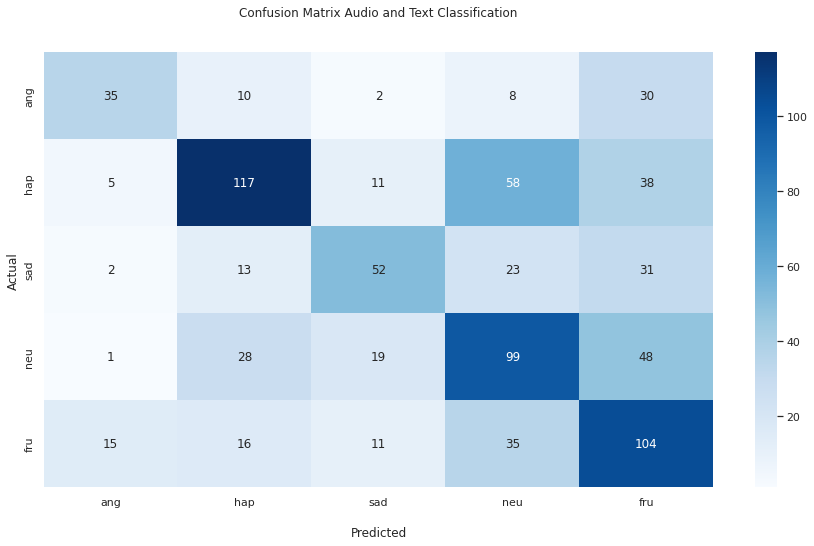

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(15,8)})
import seaborn as sns
import matplotlib.pyplot as plt
# sns.heatmap(table2,annot=True,cmap='Blues', fmt='g')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',  fmt='g')
ax.set_title('Confusion Matrix Audio and Text Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['ang','hap', 'sad', 'neu', 'fru'])
ax.yaxis.set_ticklabels(['ang','hap', 'sad', 'neu', 'fru'])

## Display the visualization of the Confusion Matrix.
plt.savefig('baseline/images/cls_audio_and_text.png')
plt.show()
